In [1]:
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda - Tesla P100-PCIE-16GB


In [3]:
'''import os
import csv

def generate_csv_with_emotions(source_directory, output_csv):
    emotion_map = {
        'ANG': 'anger',
        'DIS': 'disgust',
        'FEA': 'fear',
        'HAP': 'happy',
        'NEU': 'neutral',
        'SAD': 'sad'
    }
    
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['File Path', 'Emotion'])
        
        for filename in os.listdir(source_directory):
            if filename.endswith('.wav'):
                emotion_code = filename[9:12]
                emotion_label = emotion_map.get(emotion_code)
                
                if emotion_label:
                    file_path = os.path.join(source_directory, filename)
                    writer.writerow([file_path, emotion_label])

source_dir = '/kaggle/input/cremad/AudioWAV'
output_csv = '/kaggle/working/emotion_labels.csv'
generate_csv_with_emotions(source_dir, output_csv)
'''

"import os\nimport csv\n\ndef generate_csv_with_emotions(source_directory, output_csv):\n    emotion_map = {\n        'ANG': 'anger',\n        'DIS': 'disgust',\n        'FEA': 'fear',\n        'HAP': 'happy',\n        'NEU': 'neutral',\n        'SAD': 'sad'\n    }\n    \n    with open(output_csv, mode='w', newline='') as file:\n        writer = csv.writer(file)\n        writer.writerow(['File Path', 'Emotion'])\n        \n        for filename in os.listdir(source_directory):\n            if filename.endswith('.wav'):\n                emotion_code = filename[9:12]\n                emotion_label = emotion_map.get(emotion_code)\n                \n                if emotion_label:\n                    file_path = os.path.join(source_directory, filename)\n                    writer.writerow([file_path, emotion_label])\n\nsource_dir = '/kaggle/input/cremad/AudioWAV'\noutput_csv = '/kaggle/working/emotion_labels.csv'\ngenerate_csv_with_emotions(source_dir, output_csv)\n"

In [5]:
emodb = pd.read_csv('/kaggle/input/dataframes/ravdess_df.csv')
unique_emotions = emodb['Emotions'].unique()
print("Unique Emotions in the DataFrame:", unique_emotions)


Unique Emotions in the DataFrame: ['neutral' 'disgust' 'fear' 'sad' 'happy' 'angry']


In [7]:
emodb = emodb[(emodb["Emotions"] == "neutral") | 
              (emodb["Emotions"] == "happy") | 
              (emodb["Emotions"] == "sad") | 
              (emodb["Emotions"] == "angry")]

emodb.head()

,Emotions,Path
0,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
3,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
5,sad,/kaggle/input/ravdess-emotional-speech-audio/a...
6,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
7,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [8]:
emodb.shape

(864, 2)

In [9]:
train_df = emodb.sample(frac=0.8)
test_df = emodb.drop(train_df.index)

In [10]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["Path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [11]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {
            'neutral': 0,
            'happy': 1,
            'sad': 2,
            'angry': 3,
        }
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, list(train_data["Emotions"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["Emotions"]))

In [12]:
import torch.nn as nn
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
#model.classifier = nn.Linear(model.classifier.in_features, 6)
model.to(device)

optim = AdamW(model.parameters(), lr=1e-5)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at superb/hubert-large-superb-er were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-large-superb-er and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametri

In [13]:
print(set(train_data["Emotions"]))
print(set(test_data["Emotions"]))

{'happy', 'neutral', 'angry', 'sad'}
{'happy', 'neutral', 'angry', 'sad'}


In [14]:
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Testing Accuracy: 0.1878


In [15]:
# Switch to evaluation mode
model.eval()

# Containers to collect predictions and true labels
predictions = []
true_labels = []

# Perform inference
with torch.no_grad():
    for idx in range(len(test_dataset)):
        # Prepare batch for model input
        batch = {key: torch.unsqueeze(val[idx], 0).to(device) for key, val in test_encodings.items() if key != 'labels'}
        outputs = model(**batch)  # Forward pass
        preds = predict(outputs)  # Generate predictions
        predictions.extend(preds.cpu().numpy())  # Collect predictions
        true_labels.append(test_dataset.labels[idx])  # Collect true labels

# Calculate and print the testing accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Testing Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=["neutral", "happy", "sad", "angry"]))

# Display confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))


Testing Accuracy: 0.1329

Classification Report:
              precision    recall  f1-score   support

     neutral       1.00      0.02      0.03        61
       happy       0.33      0.13      0.19        38
         sad       0.14      0.45      0.21        38
       angry       0.00      0.00      0.00        36

    accuracy                           0.13       173
   macro avg       0.37      0.15      0.11       173
weighted avg       0.46      0.13      0.10       173


Confusion Matrix:
[[ 1  3 39 18]
 [ 0  5 33  0]
 [ 0  7 17 14]
 [ 0  0 36  0]]


In [29]:
'''from torch.utils.data import DataLoader
epoch = 20

model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        epoch_loss.append(loss.item())
        
    pbar.close()    
    train_loss += epoch_loss
    train_accuracies.append(accuracy)
'''

"from torch.utils.data import DataLoader\nepoch = 20\n\nmodel.train()\n\ntrain_loss = list()\ntrain_accuracies = list()\nfor epoch_i in range(epoch):\n    print('Epoch %s/%s' % (epoch_i + 1, epoch))\n    time.sleep(0.3)\n    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)    \n    correct = 0\n    count = 0\n    epoch_loss = list()\n    \n    pbar = tqdm(train_loader)\n    for batch in pbar:\n        optim.zero_grad()\n        input_ids = batch['input_values'].to(device)\n        attention_mask = batch['attention_mask'].to(device)\n        labels = batch['labels'].to(device)\n        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)\n        loss = outputs['loss']\n        loss.backward()\n        optim.step()\n        predictions = predict(outputs)\n\n        correct += predictions.eq(labels).sum().item()\n        count += len(labels)\n        accuracy = correct * 1.0 / count\n        pbar.set_postfix({\n            'Loss': '{:.3f}'.format(l

In [49]:
torch.save(model.state_dict(), '/kaggle/working/model_55_crema.pth')

In [50]:
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)
print("labels shape:", labels.shape)

input_ids shape: torch.Size([2, 76877])
attention_mask shape: torch.Size([2, 76877])
labels shape: torch.Size([2])


Visualise the training loss and accuracy.

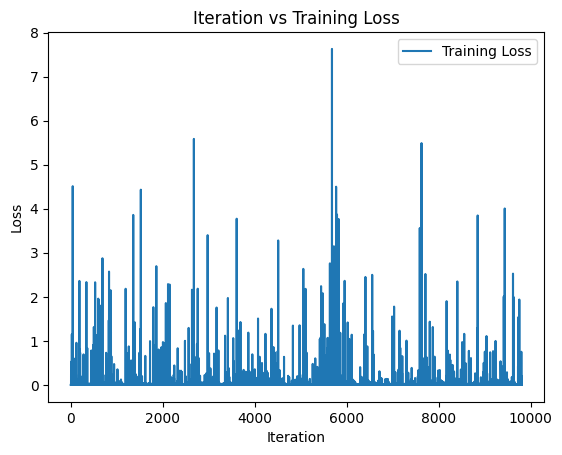

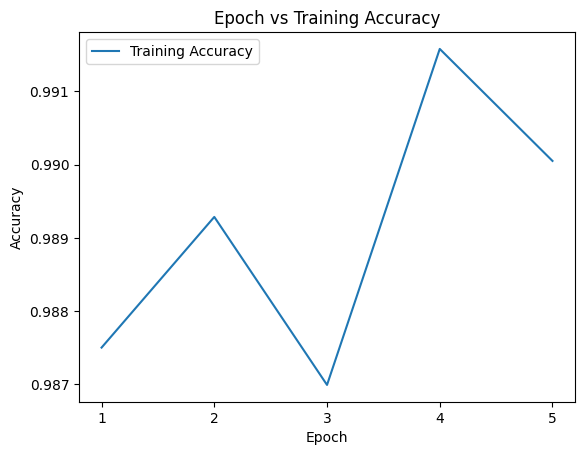

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

In [52]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels": list(), "predictions": list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        predictions = predict(outputs)
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy * 100, 4))

print("\nClassification Report:")
print(classification_report(record["labels"], record["predictions"], digits=4))

100%|██████████| 980/980 [00:51<00:00, 19.19it/s, loss=0.000, accuracy=0.944] 


The final accuracy on the test dataset: 94.3878%

Classification Report:
              precision    recall  f1-score   support

           0     0.9296    0.9659    0.9474       205
           1     0.9142    0.9608    0.9369       255
           2     0.9563    0.8866    0.9202       247
           3     0.9741    0.9634    0.9687       273

    accuracy                         0.9439       980
   macro avg     0.9435    0.9442    0.9433       980
weighted avg     0.9447    0.9439    0.9437       980



In [53]:
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

df = pd.concat([test_df.reset_index(), df_record["Model Prediction"]], axis=1)
df["Emotions"] = df.apply(lambda x: x["Emotions"][:3], axis=1)

df[df["Emotions"]!=df["Model Prediction"]]

,index,Emotions,Path,Model Prediction
1,29,ang,/kaggle/input/cremad/AudioWAV/1031_ITS_ANG_XX.wav,sad
2,37,ang,/kaggle/input/cremad/AudioWAV/1013_TAI_ANG_XX.wav,sad
3,42,ang,/kaggle/input/cremad/AudioWAV/1073_IOM_ANG_XX.wav,sad
7,64,ang,/kaggle/input/cremad/AudioWAV/1071_IOM_ANG_XX.wav,sad
8,65,ang,/kaggle/input/cremad/AudioWAV/1088_IOM_ANG_XX.wav,sad
...,...,...,...,...
974,7414,ang,/kaggle/input/cremad/AudioWAV/1020_IWW_ANG_XX.wav,sad
976,7424,hap,/kaggle/input/cremad/AudioWAV/1041_TIE_HAP_XX.wav,neu
977,7428,ang,/kaggle/input/cremad/AudioWAV/1062_ITH_ANG_XX.wav,sad
978,7436,ang,/kaggle/input/cremad/AudioWAV/1008_IEO_ANG_MD.wav,sad


Display the Confusion Matrix of the result.

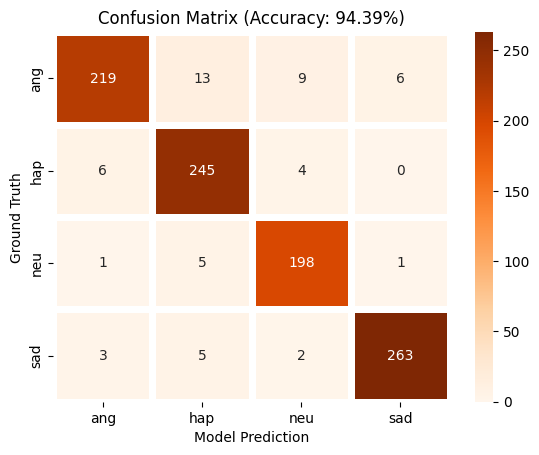

In [54]:
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [48]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

checkpoint_path = '/kaggle/working/model_50_crema.pth'

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded model weights from '{checkpoint_path}'")

model.train()

epoch = 5
train_loss = []
train_accuracies = []

for epoch_i in range(epoch):
    print(f'Epoch {epoch_i + 1}/{epoch}')
    time.sleep(0.3)
    
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    correct = 0
    count = 0
    epoch_loss = []
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        loss.backward()
        optim.step()
        
        predictions = predict(outputs) 
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct / count
        pbar.set_postfix({'Loss': f'{loss.item():.3f}', 'Accuracy': f'{accuracy:.3f}'})
        
        epoch_loss.append(loss.item())
    
    pbar.close()
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Loaded model weights from '/kaggle/working/model_50_crema.pth'
Epoch 1/5


100%|██████████| 1960/1960 [08:51<00:00,  3.69it/s, Loss=0.001, Accuracy=0.988]


Epoch 2/5


100%|██████████| 1960/1960 [08:52<00:00,  3.68it/s, Loss=0.000, Accuracy=0.989]


Epoch 3/5


100%|██████████| 1960/1960 [08:51<00:00,  3.69it/s, Loss=0.000, Accuracy=0.987]


Epoch 4/5


100%|██████████| 1960/1960 [08:52<00:00,  3.68it/s, Loss=0.000, Accuracy=0.992]


Epoch 5/5


100%|██████████| 1960/1960 [08:52<00:00,  3.68it/s, Loss=0.000, Accuracy=0.990]


In [ ]:
#93.88 at 40
#93.57 at 45
#94.08 at 50
#94.39 at 55